# Topic 6: Tools of the trade
## 1 Learning on computational graphs
So far, we've been able to build and train neural networks using code that we've developed ourselves, from scratch, using only numpy to handle some vectorized linear algebra.  In particular, the structure of the neural networks that we've looked at (namely the multilayer perceptron) meant that there existed a relatively simple closed form solution for the gradient of a loss function with respect to the network's parameters.  

However, coming up with (and especially coding) the loss function gradients as our models become more complex becomes tedious, if not also a little bit difficult in some cases: the large chains of derivatives that emerge from application of the chain rule to multiple compositions of vectorized functions tend to be a lot to keep track of for meer mortals.  However, despite the complexity of this process to a human, it's very easy for a computer to keep track of these derivatives, given two specific assumptions:
- the computer knows a closed form derivative for every function applied (for example, if a computer sees a logistic function, it needs to know the derivative of that function with respect to its argument)
- the computer knows the complete chain of operations between the thing that we want to take the gradient of (the loss function) and the thing that we want to take the gradient with respect to (some parameter in a neural network).  Stated alternatively, the computer needs to have complete knowledge of the *computational graph*.

If these conditions are met, then for any variables connected by a path in the computational graph, then we can algorithmically differentiate by evaluating the chain rule over every path between variables and taking the resulting sum (over all paths connecting the two variables).  

This type of system is actually not too arduous to code, but it *is* arduous to code in a way that is extremely general (we need to manually define the symbolic derivative of any function that might be used!) and in a way that is efficient enough to be used with the massive amounts of data that have come to define machine learning.  In particular, the creation of a graph computation system that can run on graphical processing units (GPUs), which are very well-suited for computing sequential tensorial operations, is pretty tough.

Fortunately, we are in the midst of a bit of a machine learning renaissance.  In particular, since 2015 we've had become available multiple computing packages that perform exactly the tasks described above.  Rather than reinvent the wheel, we (and essentially all other machine learning practitioners and researchers) are going to leverage the availability of these products to rapidly produce models that would have been considered state of the art advances just 5 or 10 years ago.  

## 2 Tools
[There are several packages that we might consider using](https://en.wikipedia.org/wiki/Comparison_of_deep-learning_software).  However, for one reason or another, the vast majority of users have converged on two tools, which are both free and open-source, but which are each supported by a FAANG company.  These two tools are [TensorFlow](http://tensorflow.org/)(supported by Google and frequently used via its high-level API Keras) and [PyTorch](https://pytorch.org/)(supported by Facebook).  Both have a Python API, and are superb packages.  They differ in their computational strategies (although they are both converging towards something similar), but both can be used to create and differentiate complex neural networks and train those networks in parallel on GPUs.

In the past, this course has been taught using TensorFlow.  However, due to some recent major changes to how TensorFlow works, and the resulting abundance of deprecated documentation, it has become a bit of a challenge to get going.  This time around, we are going to use PyTorch.  (Note that there are other compelling reasons to use PyTorch: its syntax is widely though to be more intuitive and easier to debug, closely mirrors Numpy and is a bit easier to install. 

Installing pytorch is easy.  Just go to https://pytorch.org/get-started/locally/ and select appropriate installation mechanism for your system (I used pip).  If you have a GPU and would like to use it, be sure that you have either CUDA 9.2 or 10 [installed on your system](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html)!

## 3 Defining a model in PyTorch
Let's see if we can reproduce our multilayer perceptron with a single hidden layer from Notebook 5.  We'll begin by importing torch, a helper submodule called torch.nn (which gives us convenient syntax to define *layers*), and the set of differentiable functions available to us, contained in torch.nn.functional.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Now, we'd like to define a neural network.  Pytorch sort of thinks of a neural network as a big function, which is going to be called a Module. A module has a number of methods that we can get generated for us automatically (in particular the function that computes the derivative, by using a python class that inherits from torch.nn.Module, and possess both a .__init__ and .forward method.

In [2]:
class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(784,256) # Transform from input to hidden layer
        self.l2 = nn.Linear(256,10) # Transform from hidden layer to logits
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        x = torch.sigmoid(self.l1(x))
        x = self.l2(x)
        return x

And that's it.  Our model is fully defined: ultimately multilayer perceptrons just aren't particularly complex models.  Now we'll need to load our dataset.  There are lots of ways of doing this for MNIST, including a built-in mechanism through torch itself, but we already know how to do this via scikit.

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
X/=255.
y = y.astype(int)
X,X_test,y,y_test = train_test_split(X,y)

Next, we'll need to turn these into pytorch tensors (rather than numpy tensors)

In [5]:
X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)

Next, since I'm planning on running this on my GPU, I'm going to cast these to single-precision floating point numbers (GPUs do computations on float32 objects rather than the system default of float64)

In [6]:
X = X.to(torch.float32)
X_test = X_test.to(torch.float32)

Finally, if I have a GPU available, I need to transfer these arrays into my GPU's memory.  We'll query to ensure that we have a GPU available and ready before we do this.  **Note that this might take several minutes the first time you do this on your system, as cuda compiles the instruction set for the GPU.**

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

X = X.to(device)
X_test = X_test.to(device)
y = y.to(device)
y_test = y_test.to(device)

Finally, we'll turn this into a TensorDataset object, which has some nice extra features compared to standard arrays, and then put them into loaders, which are just python generators that will yield up our dataset a few chunks at a time.

In [8]:
from torch.utils.data import TensorDataset

training_data = TensorDataset(X,y)
test_data = TensorDataset(X_test,y_test)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

The last step before we run gradient descent is to initialize our model (we just defined the class above, we didn't instantiate it) and to define our loss function.

In [9]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

Note that in the above, I've call .to(device) on the model as well.  This is a method that was inherited from the base class nn.Module, and it iteratively transfers all of the parameters contained in that class to the GPU as well (if we're using one).  

Finally, we can optimize our model parameters.  We have been using an optimization method that is simply called gradient descent, because it's easy to understand and easier to program.  There are, however, different variants on gradient descent that might work better or worse for a given problem.  Taken collectively, these variants are referred to as *optimizers* in the ML parlance.  In this case, we'll use one called [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/), which is itself builds on another optimizer called RMSProp (which automatically adapts the learning rate based on whether the gradient changes sign) by adding something called *momentum*.  We'll return to these optimizers soon, but for now, let's just view it as a fancy way of doing gradient descent.  We can instantiate like so:

In [10]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)   

Finally, we can do gradient descent in a loop as usual.  Here we use *epoch* to refer to a complete pass through the dataset.  Heretofore, that's corresponded to one time computing the gradient and using it to adjust the parameters.  Here, we're actually only looking at a (random) subset of the entire dataset at once, so there is an inner loop over all the random subsets (batches) of data.

In [11]:
epochs = 25
# Loop over the data
for epoch in range(epochs):
    # Loop over each subset of data
    for d,t in train_loader:
        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    # After each epoch, compute the test set accuracy
    total=0
    correct=0
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += t.size(0)
        correct += (predicted==t).sum()
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),(100.*correct/total).item())

0 0.4474763870239258 90
1 0.27057772874832153 91
2 0.07109236717224121 93
3 0.21321718394756317 93
4 0.3321465253829956 94
5 0.08503623306751251 94
6 0.055162690579891205 95
7 0.03695601224899292 95
8 0.326729953289032 95
9 0.05534758418798447 95
10 0.054865218698978424 96
11 0.47423043847084045 96
12 0.04437656328082085 96
13 0.33325549960136414 96
14 0.027702713385224342 96
15 0.02966618537902832 96
16 0.07068215310573578 96
17 0.03901456668972969 97
18 0.03969453647732735 97
19 0.16384434700012207 97
20 0.03252614662051201 97
21 0.0026303052436560392 97
22 0.005696201231330633 97
23 0.01667799986898899 97
24 0.007090163417160511 97


Running this over 25 epochs, we get a test set accuracy of around 97%!  This is fantastic, and pretty much the same as human accuracy on this dataset!  As before, we can query the model weights, to get a sense for what features in the input data that the model is looking for.  To do this, we have to go through the motions of pulling our data off the GPU, detaching it from the graph, and converting it to a numpy array.

In [12]:
params = [p for p in model.l1.parameters()]
W1 = params[0].cpu().detach().numpy().T

Now we can plot a random weight.

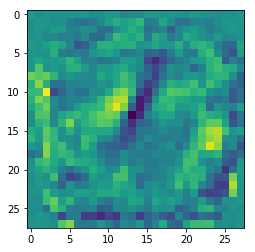

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(W1[:,np.random.randint(256)].reshape((28,28)))

## IC6A More layers
Pytorch allows for a great deal of flexibility in defining models, and this can be done very quickly.  **Add an additional hidden layer to the model defined above.  You can use however many nodes you think is reasonable for this task.  How many additional parameters does this extra hidden layer add?  Is the computational cost justified?**